# Probabilistic ML: Assignment 2
- **Deadline**: 11:59PM February 19th 
- **Submission**: You need to submit your solutions through MarkUs, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# Q1 - Image Denoising

In this problem, we will implement the sum-product Loopy **belief propagation** (Loopy-BP) method for denoising binary images which you have seen in tutorial 4.
We will consider images as matrices of size $\sqrt{n} \times \sqrt{n}$. Each element of the matrix can be either $1$ or $-1$, with $1$ representing white pixels and $-1$ representing black pixels. This is different from the $0/1$ representation commonly used for other CV tasks. This notation will be more convenient when multiplying with pixel values.

### Data preparation
Below we provide you with code for loading and preparing the image data.

First, we load a black and white image of Laika and convert it into a binary matrix of 1 and -1. So that white pixels have value 1 and black pixels have value -1.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=c163f9ebb71f7ccdf79630b6caec2be7a5097d538a73fb275090231f62af8a39
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


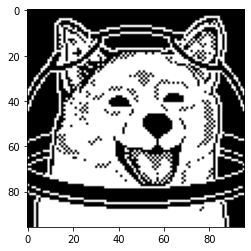

In [ ]:
!pip install wget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from os.path import exists
from wget import download
from tqdm import tqdm
filename, url = "3vaef0cog4f61.png", "https://i.redd.it/3vaef0cog4f61.png"

def load_img():
    if not exists(filename):
        download(url)

    with open(filename, 'rb') as fp:
        img2 = Image.open(fp).convert('L')
        img2 = np.array(img2)
    return (img2[:96,11:107] > 120) * 2.0 - 1

img_true = load_img()
plt.imshow(img_true, cmap='gray')

To introduce noise into the image, for each pixel, swap its value between 1 and -1 with rate 0.2. 


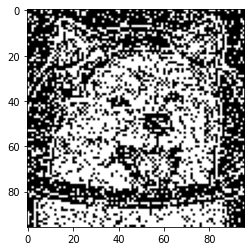

In [ ]:
def gen_noisyimg(img, noise=.05):
    swap = np.random.binomial(1, noise, size=img.shape)
    return img * (2 * swap - 1)

noise = 0.2
img_noisy = gen_noisyimg(img_true, noise)
plt.imshow(-1 * img_noisy, cmap='gray')

### The Loopy BP algorithm


Recall from lecture and tutorial, the Loopy-BP algorithm iteratively updates the messages of each node through a sum-product operation. The **sum-product** operation computes the joint inbound message through multiplication, and then marginalizes the factors through summation. This is in contrast to the **max-product** BP, which computes the maximum a-posteriori value for each variable through taking the maximum over variables.

Initialization:
 
For discrete node $x_j$ with $2$ possible states, $m_{i \rightarrow j}$ can be written as a $2$ dimensional real vector $\mathrm{m}_{i,j}$ with $m_{i \rightarrow j}(x_j) =  \mathrm{m}_{i,j}[index(x_j)]$. We initialize them uniformly to $m_{i \rightarrow j}(x_j) = 1/2$. 

(Aside: for continuous cases, $m_{i \rightarrow j}(x_j)$ is a real valued function of $x_j$. We only need to deal with the discrete case here.)

For a number of iterations:

&nbsp;&nbsp;&nbsp;&nbsp;For node $x_j$ in $\{x_s\}_{s=1}^n$:  
1. Compute the product of inbound messages from neighbours of $x_j$: 
$$\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)$$

2. Compute potentials $\psi_j(x_j) = \exp (\beta x_j y_j)$ and $\psi_{ij}(x_i,x_j) = \exp(J x_i x_j)$. This expression specifically holds when $x \in \{-1,+1\}$.

3. Marginalize over $x_j = \{-1, +1\}$ to get $m_{j \rightarrow i}(x_i)$:
$$
m_{j \rightarrow i}(x_i) = \sum_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
4. Normalize messages for stability $m_{j \rightarrow i}(x_i) =m_{j \rightarrow i}(x_i)/\sum_{x_i}m_{j \rightarrow i}(x_i)$.

Compute beliefs after message passing is done.
$$
b(x_i) \propto \psi_i(x_i) \prod_{j \in \mathcal N(i)} m_{j \rightarrow i}(x_i).
$$


You'll be tasked to perform steps 1-3 in the iterations and computing the beliefs. We will provide you with helper functions for initialization, finding neighbours, and normalization.

### Initialization
Initialize the message between neighbor pixels uniformly as $m_{j→i}(x_i) = 1/k$. Since each pixel can only be 1 or -1, message has two values $m_{j→i}(1)$ and $m_{j→i}(-1)$. We also initialize hyperparameters $J$ and $\beta$.

In [ ]:
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
init_message = np.zeros([2, num_nodes, num_nodes]) + .5
J = 1.0
beta = 1.0

Find the neighboring pixels around a given pixel, which will be used for BP updates

In [ ]:
def get_neighbors_of(node):
    """
    arguments:
     int node:  in [0,num_nodes) index of node to query
    globals:
     int num_nodes: number of nodes
    return: set(int) indices of neighbors of queried node
    """
    neighbors = []
    m = int(np.sqrt(num_nodes))
    if (node + 1) % m != 0:
        neighbors += [node + 1]
    if node % m != 0:
        neighbors += [node - 1]
    if node + m < num_nodes:
        neighbors += [node + m]
    if node - m >= 0:
        neighbors += [node - m]

    return set(neighbors)

## Q1.1 Implement message passing in BP (20 pts)

Implement the function `get_message()` that computes the message passed from node j to node i: $$
m_{j \rightarrow i}(x_i) = \sum_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
`get_message()` will be used by (provided below) `step_bp()` to perform one iteration of loopy-BP: it first normalizes the returned message from `get_message()`, and then updates the message with momentum `1.0 - step`.

In [ ]:
def get_message(node_from, node_to, messages):
    """
    arguments:
     int node_from: in [0,num_nodes) index of source node
     int node_from: in [0,num_nodes) index of target node
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float array y: (num_nodes,) observed pixel values
     float J: clique coupling strength constant
     float beta: observation to true pixel coupling strength constant
    return: array(float) of shape (2,) un-normalized message from node_from to 
    node_to
    """
    #TODO: implement your function here
    initial = 0
    output = []
    for i in (get_neighbors_of(node_from) - set([node_to])):
      initial = initial + np.log(messages[:, i, node_from])

    output.append(np.sum(np.exp((beta * y[node_from] + J) * np.array([1, -1]) + initial)))
    output.append(np.sum(np.exp((beta * y[node_from] - J) * np.array([1, -1]) + initial)))
    return np.array(output)



def step_bp(step, messages):
    """
    arguments:
     float step: step size to update messages
    return
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    """
    for node_from in range(num_nodes):
        for node_to in get_neighbors_of(node_from):
            m_new = get_message(node_from, node_to, messages)
            # normalize
            m_new = m_new / np.sum(m_new)

            messages[:, node_from, node_to] = step * m_new + (1. - step) * \
                messages[:, node_from, node_to]
    return messages

Then, run loopy BP update for 10 iterations:

In [ ]:
num_iter = 10
step = 0.5
for it in range(num_iter):
    init_message = step_bp(step, init_message)
    print(it + 1,'/',num_iter)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


## Q1.2 Computing belief from messages (10 pts)

Now, calculate the unnormalized belief for each pixel 
$$ \tilde{b}(x_i) = \psi_i(x_i) ∏_{j \in N(i)}m_{j→i}(x_i),$$
and normalize the belief across all pixels
$$ b(x_i) = \frac{\tilde{b}(x_i)}{∑_{x_j}\tilde{b}(x_j)}.$$ 

In [ ]:
def update_beliefs(messages):
    """
    arguments:
    float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float beta: observation to true pixel coupling strength constant
     float array y: (num_nodes,) observed pixel values
    returns:
     float array beliefs: (2, num_nodes), beliefs[:,i] is the belief of node i
    """
    beliefs = np.zeros([2, num_nodes])
    for node in range(num_nodes):
        #TODO: implement belief calculation here
        initial = 0
        for i in get_neighbors_of(node):
          initial = initial + np.log(messages[:, i, node])
        nominator = np.exp(beta * y[node] * np.array([1, -1]) + initial)
        denominator = np.sum(nominator)
        beliefs[:, node] = nominator/denominator

    return beliefs

# call update_beliefs() once
beliefs = update_beliefs(init_message)

Finally, to get the denoised image, we use 0.5 as the threshold and consider pixel with belief less than threshold as black while others as white. 

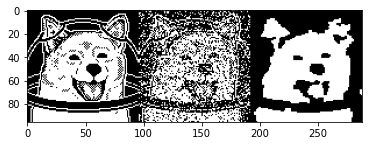

In [ ]:
pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
img_out = pred.reshape(img_true.shape)
    
plt.imshow(np.hstack([img_true, -1*img_noisy, img_out]), cmap='gray')

## Question 1.3 Momentum in belief propagation
In the sample code provided above, we performed message update with a momentum parameter `step`. In this question, you will experimentally investigate how momentum affects the characteristics of convergence.




### Question 1.3.1 (5 pts)
Complete the function `test_trajectory` below to obtain predicted image after each step of message passing. Return predicted images as list.

In [ ]:
def test_trajectory(step_size, max_step=10):
    """
    step_size: step_size to update messages in each iteration
    max_step: number of steps
    """
    # re-initialize each time
    messages = np.zeros([2, num_nodes, num_nodes]) + .5
    images = []

    # solution:
    for step in range(max_step):
        messages = step_bp(step_size, messages)
        beliefs = update_beliefs(messages)
        pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
        output = pred.reshape(img_true.shape)
        images.append(output)
    return images

        

### Question 1.3.2 (5 pts)
Use test trajectory to create image serieses for `step size` 0.1, 0.3, and 1.0, each with 10 steps. Display these images with `plot_series' provided below. 

In the textbox below, 1. comment on what happens when a large step size is used for too many iterations. 2. how would you adjust other hyperparameters to counteract this effect?

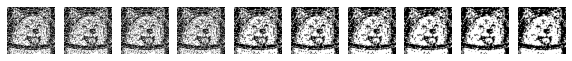

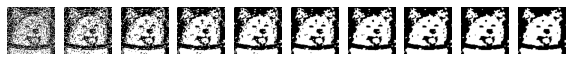

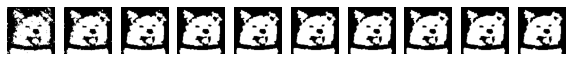

In [ ]:
def plot_series(images):
  n = len(images)
  fig, ax = plt.subplots(1, n)
  for i in range(n):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
  fig.set_figwidth(10)
  fig.show()

#Solution:

#step size = 0.1
images_fir = test_trajectory(0.1, 10)

#step size = 0.3
images_sec = test_trajectory(0.3, 10)

#step size = 1.0
images_thi = test_trajectory(1.0, 10)

plot_series(images_fir)
plot_series(images_sec)
plot_series(images_thi)

    


### Response to 1.3.2 (Enter your response below):
1. From the plots we could see that when a large step size is used for too many iterations, the convergence is fast and the images may not show too much changes across steps.

2. We can use smaller step size or reduce the number of iterations to counteract this effect.



## Question 1.4 Noise level, $beta$ and overfitting.
In this question, we will study how the level of noise in the image influences our choice in the hyperparameter $\beta$.

### Question 1.4.1 (5 pts)
First, generate and display images with noise of $0.05$, $0.3$.
In the text box below, comment on what would happen if noise was set to $0.5$ and $1.0$

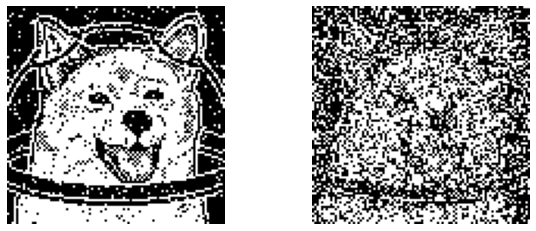

In [ ]:
# Solution
# generate noisy images with different noise levels
noise_levels = [0.05, 0.3]
imgs = []
for noise in noise_levels:
    img_noisy = gen_noisyimg(img_true, noise)
    imgs.append(-1*img_noisy)

# display images with different noise levels
plot_series(imgs)


### Response to 1.4.1 (enter your response below):
If the noise level is set to $0.5$, then about half of the pixels will have their values flipped, so the image will become very difficult to recognize. If the noise level is set to $1.0$, the white area in the original image will become black and the black area in the original image will become white.

### Question 1.4.2 (5 pts)
Now, perform image denoising on images with noise levels $0.05$ and $0.3$ using $\beta=0.5$, $\beta=1.0$, $\beta=2.5$, and $\beta=5.0$. Set step size to 0.8 and max_step to 5. Plot the denoised images (if reusing `test_trajectory`, you should plot 8 image serieses).
In text box below, comment on what you observe and provide a brief explanation on why this might occur.

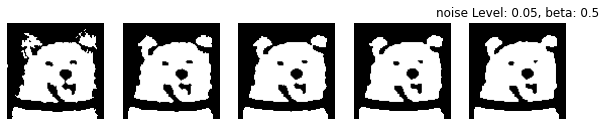

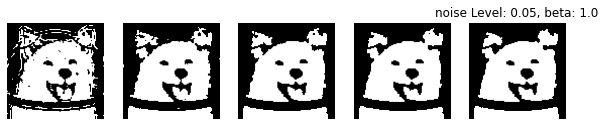

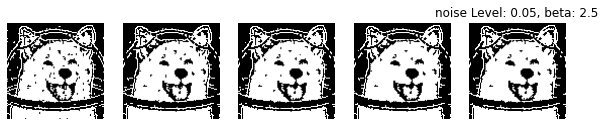

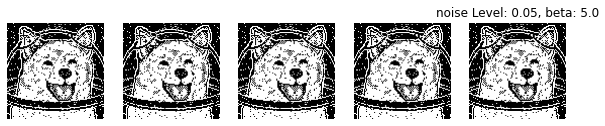

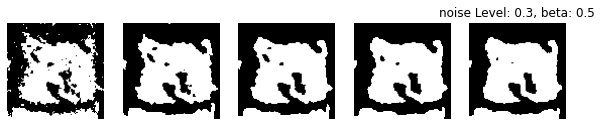

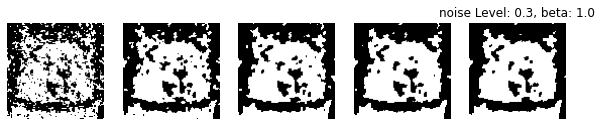

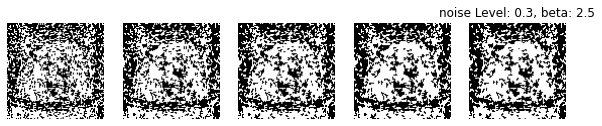

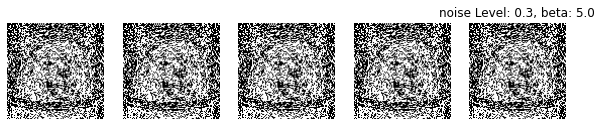

In [ ]:
# solution
noise_levels = [0.05, 0.3]
betas = [0.5, 1.0, 2.5, 5.0]
step_size = 0.8
max_step = 5

for noise in noise_levels:
    noisy_img = gen_noisyimg(img_true, noise)
    for beta in betas:
        messages = np.zeros([2, num_nodes, num_nodes]) + .5
        y = noisy_img.flatten()
        images = test_trajectory(step_size, max_step)
        output = [np.round(image.reshape(img_true.shape)) for image in images]
        plot_series(output)
        plt.title(f"noise Level: {noise}, beta: {beta}")
        plt.show()


### Response to 1.4.2 (enter your response below):
From the plots we could see that under the same noise level, as the value of $\beta$ increase, the images become more denoised and clearer, maybe increase the value of $\beta$ could make the algorithm give more weight to the observations and less weight to the prior beliefs.
 \\
And under the same $\beta$ value, increasing the noise level from 0.05 to 0.3 results in less clear images.
